In [1]:
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms

raw_dataset = SEEDDataset(
    root_path='./SEED/SEED_EEG/Preprocessed_EEG',
    io_path = 'E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,  # Disable transforms
    label_transform=None,
    num_worker=4
)

raw_sample = raw_dataset[0]
print(f"Raw EEG data shape: {raw_sample[0].shape}")  # Should be [62, ...] for SEED
print(f"Label: {raw_sample[1]}")  # Should be a number between 0 and 3

[2024-12-11 05:29:35] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


Raw EEG data shape: (62, 200)
Label: {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 10, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0'}


In [2]:
import numpy as np
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut=4, highcut=47, fs=200, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

In [3]:
filtered_data_list = []
labels_list = []

for idx in range(len(raw_dataset)):
    eeg_data, label = raw_dataset[idx]
    
    # Apply the bandpass filter
    filtered_data = bandpass_filter(eeg_data, lowcut=4, highcut=47, fs=200)
    
    # Store the filtered data and corresponding label
    filtered_data_list.append(filtered_data)
    labels_list.append(label)

    # Print progress
    if idx % 5 == 0:
        print(f"Processed sample {idx}/{len(raw_dataset)}")

print("Bandpass filtering completed for all samples.")

# Verify the shape of the filtered data
print(f"Filtered EEG Data Shape: {filtered_data_list[0].shape}")
print(f"Label: {labels_list[0]}")


Processed sample 0/152730
Processed sample 5/152730
Processed sample 10/152730
Processed sample 15/152730
Processed sample 20/152730
Processed sample 25/152730
Processed sample 30/152730
Processed sample 35/152730
Processed sample 40/152730
Processed sample 45/152730
Processed sample 50/152730
Processed sample 55/152730
Processed sample 60/152730
Processed sample 65/152730
Processed sample 70/152730
Processed sample 75/152730
Processed sample 80/152730
Processed sample 85/152730
Processed sample 90/152730
Processed sample 95/152730
Processed sample 100/152730
Processed sample 105/152730
Processed sample 110/152730
Processed sample 115/152730
Processed sample 120/152730
Processed sample 125/152730
Processed sample 130/152730
Processed sample 135/152730
Processed sample 140/152730
Processed sample 145/152730
Processed sample 150/152730
Processed sample 155/152730
Processed sample 160/152730
Processed sample 165/152730
Processed sample 170/152730
Processed sample 175/152730
Processed samp

In [4]:
print(len(labels_list))

152730


In [54]:
import numpy as np
import random

def generate_minibatch(filtered_data_list, labels_list, batch_size=32):
    """
    Generate a minibatch reflecting the natural distribution of positive and negative pairs.

    Args:
        filtered_data_list: List of filtered EEG data.
        labels_list: List of corresponding labels.
        batch_size: Number of pairs in each minibatch.

    Returns:
        A tuple (minibatch, pair_labels), where:
        - minibatch: List of tuples (sample_A, sample_B, emotion_A, emotion_B)
        - pair_labels: List indicating if the pair is positive (1) or negative (0)
    """
    # Get unique (subject_id, trial_id, emotion) tuples
    subject_trials = [(label['subject_id'], label['trial_id'], label['emotion']) for label in labels_list]
    unique_subject_trials = list(set(subject_trials))
    
    minibatch = []
    pair_labels = []
    pair_indices = []

    # Generate pairs reflecting the natural distribution
    for _ in range(batch_size):
        (subject_A, trial_A, emotion_A), (subject_B, trial_B, emotion_B) = random.sample(unique_subject_trials, 2)

        indices_A = [i for i, label in enumerate(labels_list) if label['subject_id'] == subject_A and label['trial_id'] == trial_A]
        indices_B = [i for i, label in enumerate(labels_list) if label['subject_id'] == subject_B and label['trial_id'] == trial_B]

        if indices_A and indices_B:
            index_A = random.choice(indices_A)
            index_B = random.choice(indices_B)
            minibatch.append((filtered_data_list[index_A], filtered_data_list[index_B], emotion_A, emotion_B))
            pair_label = 1 if emotion_A == emotion_B else 0
            pair_labels.append(pair_label)
            pair_indices.append((index_A, index_B))

    return minibatch, pair_labels, pair_indices


In [55]:
batch_size = 2000

# Generate minibatches with the updated function
minibatch, pair_labels , pair_indices = generate_minibatch(filtered_data_list, labels_list, batch_size=batch_size)

print(f"Generated {len(minibatch)} pairs.")
positive_pairs = []
negative_pairs = []
# Print a few pairs for verification
for i, (sample_A, sample_B, emotion_A, emotion_B) in enumerate(minibatch):
    pair_type = "Positive" if pair_labels[i] == 1 else "Negative"
    if pair_labels[i] == 1:
        positive_pairs.append((sample_A, sample_B, emotion_A, emotion_B))
    else:
        negative_pairs.append((sample_A, sample_B, emotion_A, emotion_B))
    print(f"Pair {i+1} ({pair_type}): Emotion A = {emotion_A}, Emotion B = {emotion_B}")

print(f"Positive pairs: {len(positive_pairs)}")
print(f"Negative pairs: {len(negative_pairs)}")


Generated 2000 pairs.
Pair 1 (Negative): Emotion A = -1, Emotion B = 1
Pair 2 (Positive): Emotion A = 0, Emotion B = 0
Pair 3 (Positive): Emotion A = 1, Emotion B = 1
Pair 4 (Negative): Emotion A = 1, Emotion B = -1
Pair 5 (Negative): Emotion A = -1, Emotion B = 0
Pair 6 (Negative): Emotion A = -1, Emotion B = 0
Pair 7 (Positive): Emotion A = -1, Emotion B = -1
Pair 8 (Negative): Emotion A = 0, Emotion B = -1
Pair 9 (Negative): Emotion A = -1, Emotion B = 1
Pair 10 (Negative): Emotion A = 0, Emotion B = -1
Pair 11 (Positive): Emotion A = 1, Emotion B = 1
Pair 12 (Positive): Emotion A = 1, Emotion B = 1
Pair 13 (Negative): Emotion A = 0, Emotion B = -1
Pair 14 (Positive): Emotion A = -1, Emotion B = -1
Pair 15 (Negative): Emotion A = 0, Emotion B = 1
Pair 16 (Positive): Emotion A = 0, Emotion B = 0
Pair 17 (Negative): Emotion A = -1, Emotion B = 1
Pair 18 (Negative): Emotion A = -1, Emotion B = 1
Pair 19 (Negative): Emotion A = 0, Emotion B = 1
Pair 20 (Negative): Emotion A = 0, Emotion

In [7]:
import torch
import torch.nn as nn

class BaseEncoder(nn.Module):
    def __init__(self, num_channels=62, temporal_filter_length=48, num_spatial_filters=16, num_temporal_filters=16):
        super(BaseEncoder, self).__init__()
        
        # Spatial Convolution: [num_channels, timepoints] -> [num_spatial_filters, timepoints]
        self.spatial_conv = nn.Conv1d(in_channels=num_channels, out_channels=num_spatial_filters, kernel_size=1)
        
        # Temporal Convolution: [num_spatial_filters, timepoints] -> [num_temporal_filters, timepoints]
        self.temporal_conv = nn.Conv1d(in_channels=num_spatial_filters, out_channels=num_temporal_filters, kernel_size=temporal_filter_length, padding='same')
        
        # Activation Function
        self.activation = nn.ReLU()

    def forward(self, x):
        # x shape: [batch_size, num_channels, timepoints]
        x = self.spatial_conv(x)
        x = self.activation(x)
        x = self.temporal_conv(x)
        x = self.activation(x)
        
        return x

# Initialize the Base Encoder
base_encoder = BaseEncoder()

# Verify the model with a sample input
sample_input = torch.randn(32, 62, 200)  # Batch size = 32, Channels = 62, Timepoints = 200
output = base_encoder(sample_input)

print(f"Input Shape: {sample_input.shape}")
print(f"Output Shape: {output.shape}")  # Expected: [32, 16, 200]


Input Shape: torch.Size([32, 62, 200])
Output Shape: torch.Size([32, 16, 200])


e:\FYP\Egg-Based Emotion Recognition\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(


In [8]:
import torch
import torch.nn as nn

class Projector(nn.Module):
    def __init__(self, num_input_filters=16, spatial_filters=32, temporal_filters=64, temporal_filter_length=4, pooling_kernel_length=24):
        super(Projector, self).__init__()

        # Spatial Convolution: [num_input_filters, timepoints] -> [spatial_filters, timepoints]
        self.spatial_conv = nn.Conv1d(in_channels=num_input_filters, out_channels=spatial_filters, kernel_size=1)

        # Temporal Convolution: [spatial_filters, timepoints] -> [temporal_filters, timepoints]
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters, out_channels=temporal_filters, kernel_size=temporal_filter_length, padding='same')

        # Average Pooling: [temporal_filters, timepoints] -> [temporal_filters, reduced_timepoints]
        self.avg_pool = nn.AvgPool1d(kernel_size=pooling_kernel_length)

        # Activation Function
        self.activation = nn.ReLU()

    def forward(self, x):
        # x shape: [batch_size, num_input_filters, timepoints]
        x = self.spatial_conv(x)
        x = self.activation(x)
        x = self.temporal_conv(x)
        x = self.activation(x)
        x = self.avg_pool(x)

        return x

# Initialize the Projector with SEED hyperparameters
projector = Projector(
    num_input_filters=16,         # Output from the base encoder
    spatial_filters=32,           # CK2 = 32
    temporal_filters=64,          # C^2K2 = 64
    temporal_filter_length=4,     # P2 = 4
    pooling_kernel_length=24      # S = 24
)

# Verify the model with a sample input
sample_input = torch.randn(32, 16, 200)  # Batch size = 32, Spatial filters = 16, Timepoints = 200
output = projector(sample_input)

print(f"Input Shape: {sample_input.shape}")
print(f"Output Shape: {output.shape}")  # Expected: [32, 64, reduced_timepoints]


Input Shape: torch.Size([32, 16, 200])
Output Shape: torch.Size([32, 64, 8])


In [89]:
import torch
import torch.nn.functional as F

def contrastive_loss(embeddings_A, embeddings_B, positive_weight=1.5 , temperature=0.07):
    """
    Compute the contrastive loss for a batch of embeddings.

    Args:
        embeddings_A: Tensor of shape [batch_size, embedding_dim] for subject A.
        embeddings_B: Tensor of shape [batch_size, embedding_dim] for subject B.
        temperature: Temperature parameter for scaling.

    Returns:
        Scalar tensor representing the contrastive loss.
    """
    # Normalize the embeddings
    embeddings_A = F.normalize(embeddings_A, dim=1)
    embeddings_B = F.normalize(embeddings_B, dim=1)

    # Compute cosine similarities
    similarity_matrix_A_B = torch.mm(embeddings_A, embeddings_B.t())  # Shape: [batch_size, batch_size]
    similarity_matrix_A_A = torch.mm(embeddings_A, embeddings_A.t())  # Shape: [batch_size, batch_size]
    similarity_matrix_B_B = torch.mm(embeddings_B, embeddings_B.t())  # Shape: [batch_size, batch_size]

    # Scale by temperature
    similarity_matrix_A_B = similarity_matrix_A_B / temperature
    similarity_matrix_A_A = similarity_matrix_A_A / temperature
    similarity_matrix_B_B = similarity_matrix_B_B / temperature

    # Mask the diagonal to exclude self-comparisons
    mask = torch.eye(similarity_matrix_A_A.size(0), dtype=torch.bool).to(embeddings_A.device)

    # For embeddings_A
    logits_A = torch.cat([similarity_matrix_A_B, similarity_matrix_A_A.masked_fill(mask, -1e9)], dim=1)
    labels = torch.arange(embeddings_A.size(0)).to(embeddings_A.device)

    # Compute weights for positive pairs
    weights = torch.ones_like(labels).float().to(embeddings_A.device)
    weights[labels < embeddings_A.size(0)] = positive_weight  # Apply weight for positive pairs

    # Compute cross-entropy loss with weights
    loss_A = F.cross_entropy(logits_A, labels, reduction='none')  # Compute loss per sample
    loss_A = (weights * loss_A).mean()  # Apply weights and average

    # For embeddings_B
    logits_B = torch.cat([similarity_matrix_A_B.t(), similarity_matrix_B_B.masked_fill(mask, -1e9)], dim=1)
    loss_B = F.cross_entropy(logits_B, labels, reduction='none')  # Compute loss per sample
    loss_B = (weights * loss_B).mean()  # Apply weights and average

    # Total loss (averaging both directions)
    loss = (loss_A + loss_B) / 2

    return loss


In [90]:
batch_size = 32
embedding_dim = 64

# Simulated embeddings for subject A and subject B
embeddings_A = torch.randn(batch_size, embedding_dim)
embeddings_B = torch.randn(batch_size, embedding_dim)

# Compute the contrastive loss
loss = contrastive_loss(embeddings_A, embeddings_B)

# Print the loss value
print(f"Contrastive Loss: {loss.item():.4f}")

Contrastive Loss: 8.1367


In [91]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
class ContrastiveModel(torch.nn.Module):
    def __init__(self, base_encoder, projector):
        super(ContrastiveModel, self).__init__()
        self.base_encoder = base_encoder
        self.projector = projector

    def forward(self, x):
        x = self.base_encoder(x)
        x = self.projector(x)
        x = x.flatten(1)
        x = F.normalize(x, dim=1)
        return x

In [92]:
# Assuming base_encoder and projector are already defined
model = ContrastiveModel(base_encoder, projector)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Verify the model with a sample input
sample_input = torch.randn(32, 62, 200).to(device)  # Batch size = 32, Channels = 62, Timepoints = 200
output = model(sample_input)

print(f"Input Shape: {sample_input.shape}")
print(f"Output Shape: {output.shape}")  # Expected: [32, embedding_dim]


Input Shape: torch.Size([32, 62, 200])
Output Shape: torch.Size([32, 512])


In [93]:
import torch
from torch.utils.data import Dataset

class EEGDataset(Dataset):
    def __init__(self, minibatch, pair_labels):
        self.data = minibatch  # List of (sample_A, sample_B) pairs
        self.labels = pair_labels        # List of corresponding labels (1 for positive, 0 for negative)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_A, sample_B , emotion_A , emotion_B = self.data[idx]
        label = self.labels[idx]

        sample_A = torch.tensor(sample_A.copy(), dtype=torch.float32)
        sample_B = torch.tensor(sample_B.copy(), dtype=torch.float32)

        sample_A = (sample_A - sample_A.mean()) / (sample_A.std() + 1e-6)
        sample_B = (sample_B - sample_B.mean()) / (sample_B.std() + 1e-6)
        
        emotion_A = torch.tensor(emotion_A, dtype=torch.long)
        emotion_B = torch.tensor(emotion_B, dtype=torch.long)
        
        label = torch.tensor(label, dtype=torch.long)
        
        return sample_A, sample_B, label , emotion_A , emotion_B


In [94]:
import random
from sklearn.utils import shuffle

def loso_split(minibatch, pair_labels, labels_list, pair_indices):
    # Get unique subjects
    subjects = set(label['subject_id'] for label in labels_list)
    print(f"Unique Subjects: {subjects}")

    for test_subject in subjects:
        print(f"\nUsing Subject {test_subject} for testing...")

        # Split data based on the test_subject
        train_data = []
        train_labels = []
        test_data = []
        test_labels = []

        for (pair, label, (index_A, index_B)) in zip(minibatch, pair_labels, pair_indices):
            subject_A = labels_list[index_A]['subject_id']
            subject_B = labels_list[index_B]['subject_id']

            if subject_A == test_subject or subject_B == test_subject:
                test_data.append(pair)             # Pair (sample_A, sample_B, emotion_A, emotion_B)
                test_labels.append((label, labels_list[index_A]['emotion'], labels_list[index_B]['emotion']))
            else:
                train_data.append(pair)            # Pair (sample_A, sample_B, emotion_A, emotion_B)
                train_labels.append((label, labels_list[index_A]['emotion'], labels_list[index_B]['emotion']))

        # Shuffle the test data to mix positive and negative pairs
        test_data, test_labels = shuffle(test_data, test_labels, random_state=42)

        # Print sizes for debugging
        print(f"Train Data Size: {len(train_data)}")
        print(f"Test Data Size: {len(test_data)}")

        yield train_data, train_labels, test_data, test_labels


In [95]:
from torch.utils.data import DataLoader

batch_size = 64

for train_data, train_labels, test_data, test_labels in loso_split(minibatch, pair_labels, labels_list, pair_indices):
    # Create Dataset instances
    train_dataset = EEGDataset(train_data, train_labels)
    test_dataset = EEGDataset(test_data, test_labels)

    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train Dataset Size: {len(train_dataset)}")
    print(f"Test Dataset Size: {len(test_dataset)}")

    # Break after the first LOSO split for demonstration
    break


Unique Subjects: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

Using Subject 1 for testing...
Train Data Size: 1753
Test Data Size: 247
Train Dataset Size: 1753
Test Dataset Size: 247


In [96]:
# Verify train DataLoader
for batch_idx, (sample_A, sample_B, label, emotion_A, emotion_B) in enumerate(train_loader):
    print(f"Train Batch {batch_idx + 1}:")
    print(f"Sample A Shape: {sample_A.shape}")
    print(f"Sample B Shape: {sample_B.shape}")
    print(f"Label: {label}")
    print(f"Emotion A: {emotion_A}")
    print(f"Emotion B: {emotion_B}")
    break  # Just one batch for demonstration

# Verify test DataLoader
for batch_idx, (sample_A, sample_B, label, emotion_A, emotion_B) in enumerate(test_loader):
    print(f"Test Batch {batch_idx + 1}:")
    print(f"Sample A Shape: {sample_A.shape}")
    print(f"Sample B Shape: {sample_B.shape}")
    print(f"Label: {label}")
    print(f"Emotion A: {emotion_A}")
    print(f"Emotion B: {emotion_B}")
    break  # Just one batch for demonstration


Train Batch 1:
Sample A Shape: torch.Size([64, 62, 200])
Sample B Shape: torch.Size([64, 62, 200])
Label: tensor([[ 0,  1, -1],
        [ 0,  1, -1],
        [ 1,  0,  0],
        [ 0,  1, -1],
        [ 0,  1,  0],
        [ 1,  1,  1],
        [ 0,  1, -1],
        [ 1,  1,  1],
        [ 0, -1,  0],
        [ 0, -1,  0],
        [ 0, -1,  1],
        [ 0,  0, -1],
        [ 0, -1,  0],
        [ 0, -1,  0],
        [ 0,  1,  0],
        [ 0,  0,  1],
        [ 0,  1, -1],
        [ 0,  1,  0],
        [ 0, -1,  1],
        [ 1,  0,  0],
        [ 0,  0, -1],
        [ 1,  1,  1],
        [ 0,  0,  1],
        [ 0,  1,  0],
        [ 0, -1,  1],
        [ 0, -1,  0],
        [ 0, -1,  1],
        [ 0, -1,  1],
        [ 0,  0,  1],
        [ 0, -1,  0],
        [ 0, -1,  0],
        [ 0,  0,  1],
        [ 0, -1,  1],
        [ 1, -1, -1],
        [ 0, -1,  0],
        [ 0,  1, -1],
        [ 0,  0, -1],
        [ 0, -1,  1],
        [ 0,  0, -1],
        [ 0,  0,  1],
        [ 0, -

In [97]:
import torch
torch.cuda.is_available()
torch.cuda.empty_cache()

In [98]:
import torch
import torch.nn.functional as F

def compute_accuracy(embeddings_A, embeddings_B, labels, threshold=0.5):
    """
    Compute the accuracy of the model's predictions.

    Args:
        embeddings_A: Tensor of embeddings for sample A (shape: [batch_size, embedding_dim]).
        embeddings_B: Tensor of embeddings for sample B (shape: [batch_size, embedding_dim]).
        labels: Tensor of ground truth labels (1 for positive pairs, 0 for negative pairs).
        threshold: Threshold for determining if a pair is positive or negative.

    Returns:
        Accuracy as a float.
    """
    # Ensure embeddings are normalized
    embeddings_A = F.normalize(embeddings_A, dim=1)
    embeddings_B = F.normalize(embeddings_B, dim=1)

    # Compute cosine similarity between pairs
    similarities = F.cosine_similarity(embeddings_A, embeddings_B)

    # Convert similarities to binary predictions based on the threshold
    predictions = (similarities > threshold).float()

    # Calculate accuracy
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total

    return accuracy


In [99]:
import torch
torch.cuda.empty_cache()

In [100]:
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import time

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/runs/contrastive_learning')

# Early stopping settings
patience = 10
num_epochs = 100
batch_size = 32
checkpoint_dir = './Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# LOSO Cross-Validation
for fold, (train_data, train_labels, test_data, test_labels) in enumerate(loso_split(minibatch, pair_labels, labels_list, pair_indices)):
    test_subject = list(set(label['subject_id'] for label in labels_list))[fold]
    print(f"\n=== Starting LOSO Iteration: Subject {test_subject} Held Out ===")

    # Create DataLoader for the current LOSO split
    train_loader = DataLoader(EEGDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)

    # Initialize the model for each LOSO iteration
    model = ContrastiveModel(base_encoder, projector)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=0.015)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

    # Reset early stopping variables
    best_loss = float('inf')
    epochs_no_improve = 0
    checkpoint_path = os.path.join(checkpoint_dir, f'model_subject_{test_subject}.pth')

    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        model.train()
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        for i, (sample_A, sample_B, label, _, _) in enumerate(train_loader):
            sample_A, sample_B, label = sample_A.to(device), sample_B.to(device), label.to(device)

            # Forward pass
            embeddings_A = model(sample_A)
            embeddings_B = model(sample_B)

            # Compute contrastive loss
            loss = contrastive_loss(embeddings_A, embeddings_B)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            # Accumulate loss and accuracy
            epoch_loss += loss.item()

            # Log batch loss and accuracy
            writer.add_scalar(f'Batch Loss/Subject {test_subject}', loss.item(), epoch * len(train_loader) + i)

            print(f"  Batch [{i+1}/{len(train_loader)}] - Loss: {loss.item():.4f} ")

        # Scheduler step
        scheduler.step()

        # Calculate average loss and accuracy for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)

        # Log epoch loss and accuracy
        writer.add_scalar(f'Loss/Subject {test_subject}', avg_epoch_loss, epoch)

        print(f"Epoch [{epoch+1}] - Average Loss: {avg_epoch_loss:.4f} ")

        # Early stopping and checkpoint saving
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"  Loss improved. Model saved to {checkpoint_path}")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        epoch_end_time = time.time()
        print(f"Epoch Duration: {epoch_end_time - epoch_start_time:.2f} seconds")

# Close the TensorBoard writer
writer.close()


Unique Subjects: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

Using Subject 1 for testing...
Train Data Size: 1753
Test Data Size: 247

=== Starting LOSO Iteration: Subject 1 Held Out ===

Epoch [1/100]
  Batch [1/55] - Loss: 0.4016 
  Batch [2/55] - Loss: 1.8982 
  Batch [3/55] - Loss: 1.2540 
  Batch [4/55] - Loss: 0.7950 
  Batch [5/55] - Loss: 1.2220 
  Batch [6/55] - Loss: 1.0335 
  Batch [7/55] - Loss: 1.4877 
  Batch [8/55] - Loss: 0.8913 
  Batch [9/55] - Loss: 0.8692 
  Batch [10/55] - Loss: 1.0324 
  Batch [11/55] - Loss: 0.9270 
  Batch [12/55] - Loss: 1.1784 
  Batch [13/55] - Loss: 1.0730 
  Batch [14/55] - Loss: 1.2583 
  Batch [15/55] - Loss: 0.8431 
  Batch [16/55] - Loss: 1.2000 
  Batch [17/55] - Loss: 0.9200 
  Batch [18/55] - Loss: 0.8208 
  Batch [19/55] - Loss: 0.6719 
  Batch [20/55] - Loss: 0.8963 
  Batch [21/55] - Loss: 0.6964 
  Batch [22/55] - Loss: 1.1659 
  Batch [23/55] - Loss: 0.6693 
  Batch [24/55] - Loss: 0.7825 
  Batch [25/55] - Loss: 1.3002

In [101]:
import torch
torch.cuda.empty_cache()

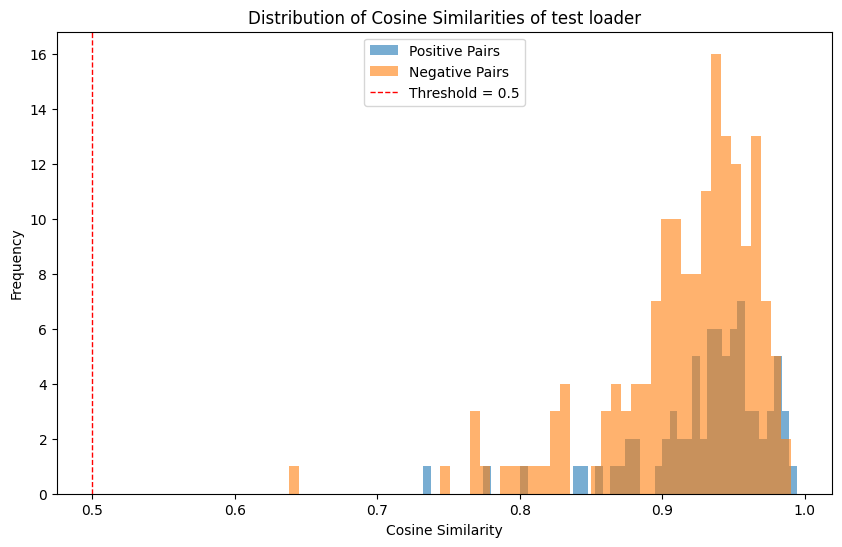

In [102]:
import matplotlib.pyplot as plt

# Collect cosine similarities for analysis
positive_similarities = []
negative_similarities = []

for sample_A, sample_B, label, _, _ in test_loader:
    sample_A, sample_B = sample_A.to(device), sample_B.to(device)
    embeddings_A = model(sample_A)
    embeddings_B = model(sample_B)
    embeddings_A = F.normalize(embeddings_A, dim=1)
    embeddings_B = F.normalize(embeddings_B, dim=1)
    
    cosine_sim = F.cosine_similarity(embeddings_A, embeddings_B)
    
    label = label.view(-1)
    
    for sim, lbl in zip(cosine_sim.detach().cpu().numpy(), label.cpu().numpy()):
        if lbl == 1:
            positive_similarities.append(sim)
        else:
            negative_similarities.append(sim)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.hist(positive_similarities, bins=50, alpha=0.6, label='Positive Pairs')
plt.hist(negative_similarities, bins=50, alpha=0.6, label='Negative Pairs')
plt.axvline(0.5, color='red', linestyle='dashed', linewidth=1, label='Threshold = 0.5')
plt.title('Distribution of Cosine Similarities of test loader')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Unique Subjects: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

Using Subject 1 for testing...
Train Data Size: 1753
Test Data Size: 247

=== Evaluating Model for LOSO Iteration: Subject 1 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 1: 1.2827
Precision for Subject 1: 0.6521
Recall for Subject 1: 0.3198
F1 Score for Subject 1: 0.1966


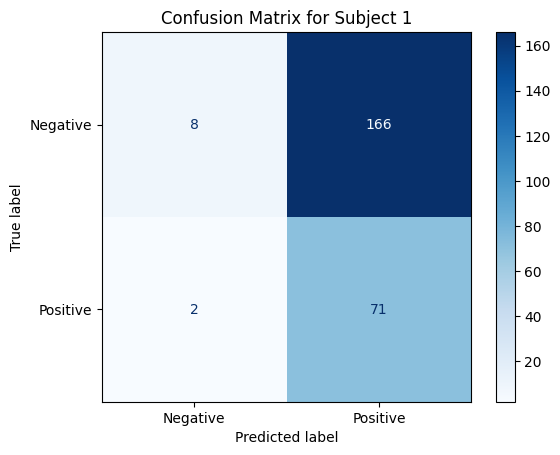


Using Subject 2 for testing...
Train Data Size: 1740
Test Data Size: 260

=== Evaluating Model for LOSO Iteration: Subject 2 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 2: 0.9571
Precision for Subject 2: 0.7948
Recall for Subject 2: 0.3115
F1 Score for Subject 2: 0.1717


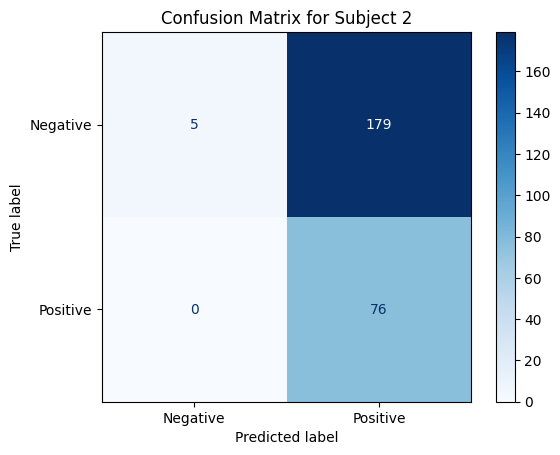


Using Subject 3 for testing...
Train Data Size: 1741
Test Data Size: 259

=== Evaluating Model for LOSO Iteration: Subject 3 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 3: 0.8732
Precision for Subject 3: 0.5878
Recall for Subject 3: 0.3436
F1 Score for Subject 3: 0.2021


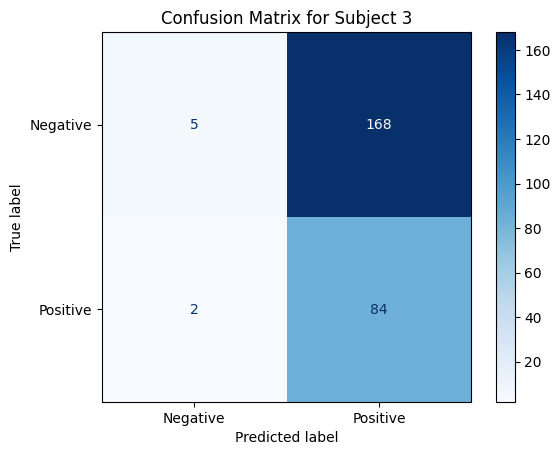


Using Subject 4 for testing...
Train Data Size: 1728
Test Data Size: 272

=== Evaluating Model for LOSO Iteration: Subject 4 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 4: 0.7945
Precision for Subject 4: 0.7945
Recall for Subject 4: 0.2978
F1 Score for Subject 4: 0.1460


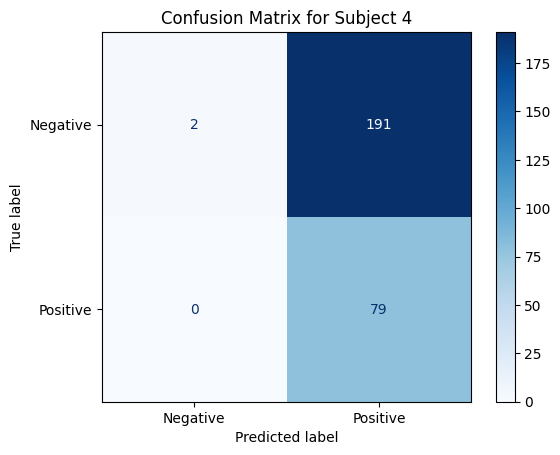


Using Subject 5 for testing...
Train Data Size: 1750
Test Data Size: 250

=== Evaluating Model for LOSO Iteration: Subject 5 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 5: 0.7295
Precision for Subject 5: 0.1267
Recall for Subject 5: 0.3560
F1 Score for Subject 5: 0.1869


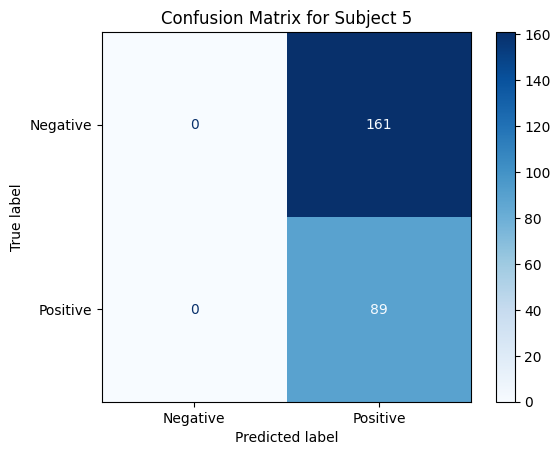


Using Subject 6 for testing...
Train Data Size: 1753
Test Data Size: 247

=== Evaluating Model for LOSO Iteration: Subject 6 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 6: 0.8296
Precision for Subject 6: 0.7874
Recall for Subject 6: 0.3117
F1 Score for Subject 6: 0.1533


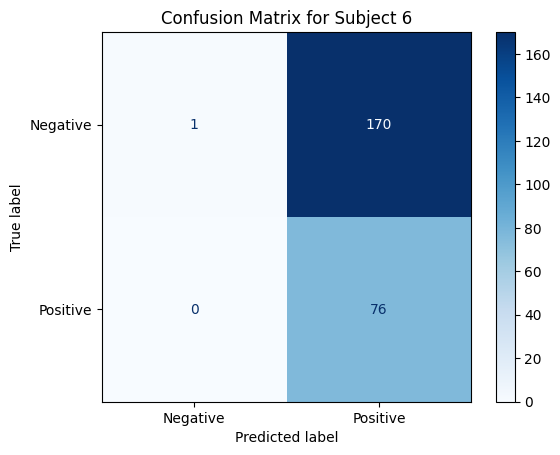


Using Subject 7 for testing...
Train Data Size: 1718
Test Data Size: 282

=== Evaluating Model for LOSO Iteration: Subject 7 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 7: 0.8943
Precision for Subject 7: 0.8039
Recall for Subject 7: 0.2801
F1 Score for Subject 7: 0.1364


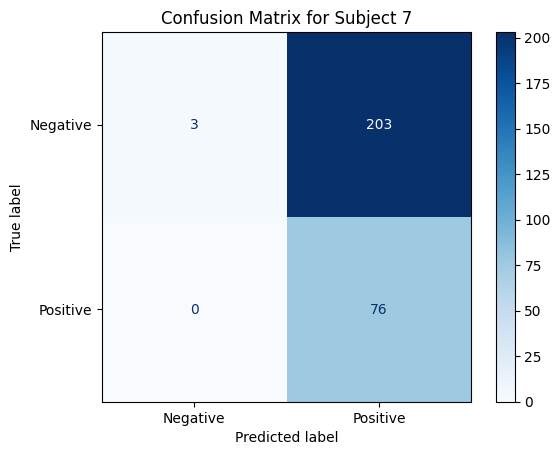


Using Subject 8 for testing...
Train Data Size: 1751
Test Data Size: 249

=== Evaluating Model for LOSO Iteration: Subject 8 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 8: 0.8067
Precision for Subject 8: 0.4433
Recall for Subject 8: 0.3293
F1 Score for Subject 8: 0.1701


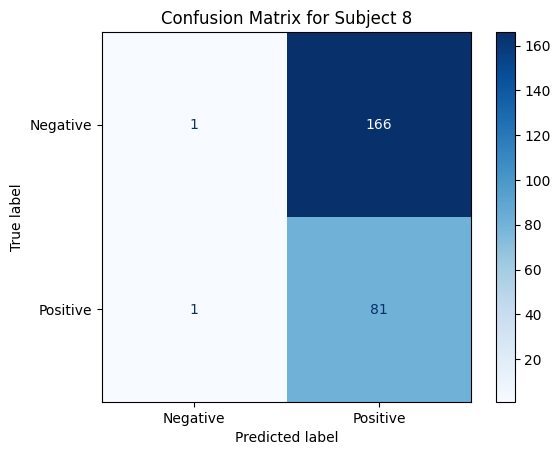


Using Subject 9 for testing...
Train Data Size: 1743
Test Data Size: 257

=== Evaluating Model for LOSO Iteration: Subject 9 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 9: 0.6972
Precision for Subject 9: 0.7835
Recall for Subject 9: 0.3268
F1 Score for Subject 9: 0.1707


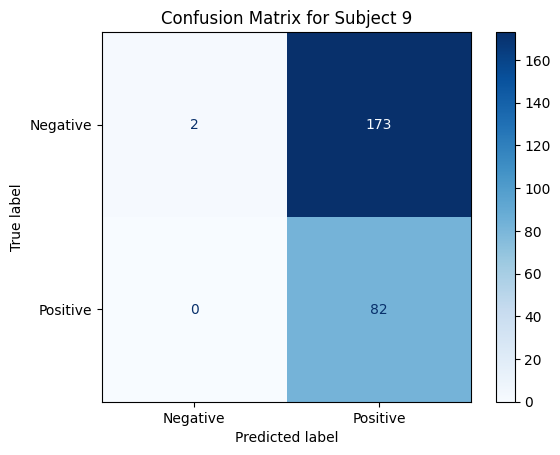


Using Subject 10 for testing...
Train Data Size: 1737
Test Data Size: 263

=== Evaluating Model for LOSO Iteration: Subject 10 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 10: 0.8466
Precision for Subject 10: 0.7905
Recall for Subject 10: 0.3080
F1 Score for Subject 10: 0.1546


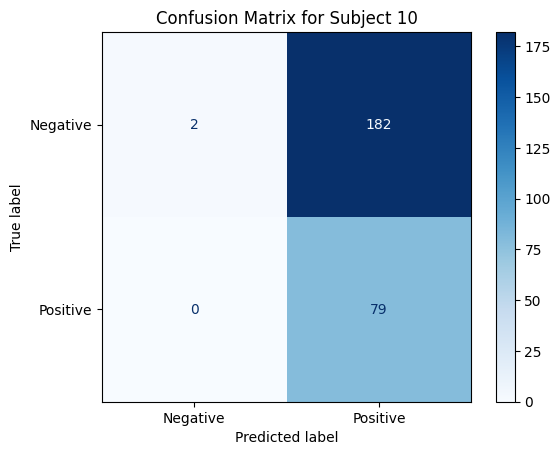


Using Subject 11 for testing...
Train Data Size: 1727
Test Data Size: 273

=== Evaluating Model for LOSO Iteration: Subject 11 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 11: 0.7553
Precision for Subject 11: 0.7877
Recall for Subject 11: 0.3150
F1 Score for Subject 11: 0.1601


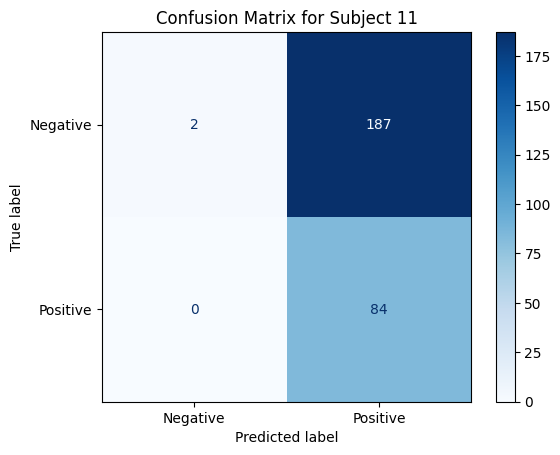


Using Subject 12 for testing...
Train Data Size: 1731
Test Data Size: 269

=== Evaluating Model for LOSO Iteration: Subject 12 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 12: 0.7900
Precision for Subject 12: 0.7992
Recall for Subject 12: 0.2825
F1 Score for Subject 12: 0.1293


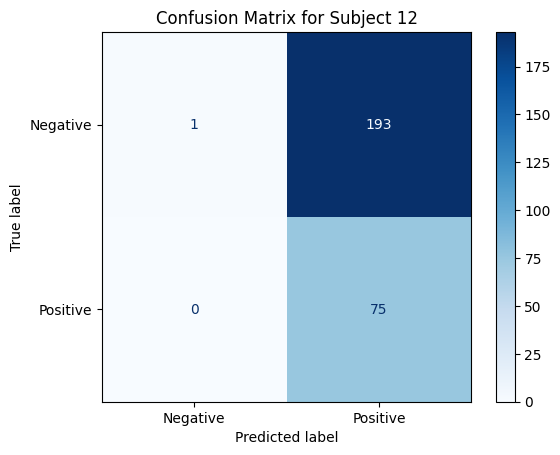


Using Subject 13 for testing...
Train Data Size: 1732
Test Data Size: 268

=== Evaluating Model for LOSO Iteration: Subject 13 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 13: 0.7695
Precision for Subject 13: 0.0928
Recall for Subject 13: 0.3022
F1 Score for Subject 13: 0.1420


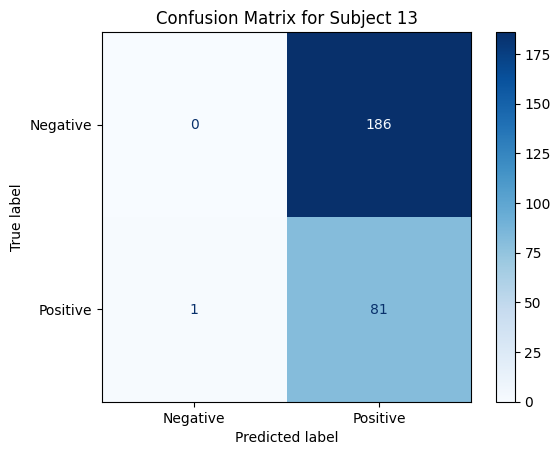


Using Subject 14 for testing...
Train Data Size: 1751
Test Data Size: 249

=== Evaluating Model for LOSO Iteration: Subject 14 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 14: 1.2769
Precision for Subject 14: 0.4617
Recall for Subject 14: 0.3213
F1 Score for Subject 14: 0.2050


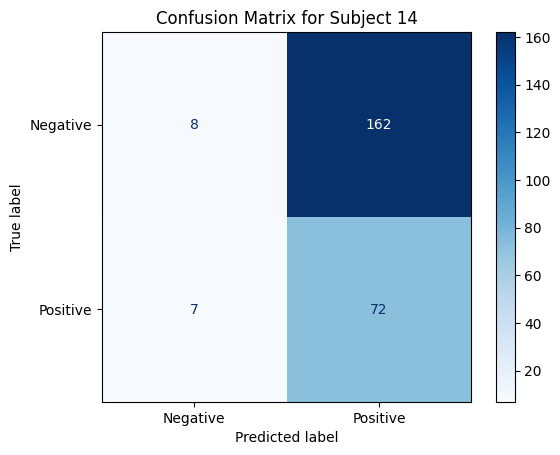


Using Subject 15 for testing...
Train Data Size: 1775
Test Data Size: 225

=== Evaluating Model for LOSO Iteration: Subject 15 Held Out ===


C:\Users\hamza\AppData\Local\Temp\ipykernel_756\4224389388.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Average Test Loss for Subject 15: 0.6210
Precision for Subject 15: 0.7845
Recall for Subject 15: 0.3200
F1 Score for Subject 15: 0.1607


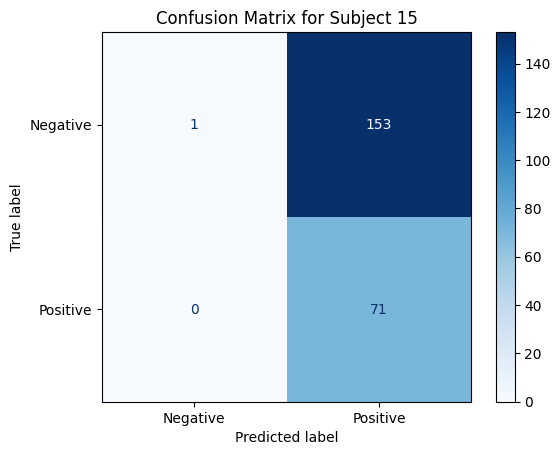

In [103]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import os

# Ensure checkpoint directory exists
checkpoint_dir = './Checkpoints'
batch_size = 32

# LOSO Evaluation Loop
for fold, (train_data, train_labels, test_data, test_labels) in enumerate(loso_split(minibatch, pair_labels, labels_list, pair_indices)):
    test_subject = list(set(label['subject_id'] for label in labels_list))[fold]
    print(f"\n=== Evaluating Model for LOSO Iteration: Subject {test_subject} Held Out ===")

    # Create DataLoader for the test set
    test_loader = DataLoader(EEGDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

    # Load the best model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model_subject_{test_subject}.pth')
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    test_loss = 0.0
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for sample_A, sample_B, label, _, _ in test_loader:
            sample_A, sample_B, label = sample_A.to(device), sample_B.to(device), label.to(device)

            # Forward pass
            embeddings_A = model(sample_A)
            embeddings_B = model(sample_B)
            
            embeddings_A = F.normalize(embeddings_A, dim=1)
            embeddings_B = F.normalize(embeddings_B, dim=1)
            

            # Compute predictions
            cosine_similarities = F.cosine_similarity(embeddings_A, embeddings_B)
            predicted_labels = (cosine_similarities > 0.68).float()

            # Collect true and predicted labels
            all_true_labels.extend(label.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

            # Compute loss
            loss = contrastive_loss(embeddings_A, embeddings_B)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Average Test Loss for Subject {test_subject}: {avg_test_loss:.4f}")

    # # Convert labels to numpy arrays
    # all_true_labels = np.array(all_true_labels)
    # all_predicted_labels = np.array(all_predicted_labels)

    all_true_labels = np.array([triplet[0] for triplet in all_true_labels])
    all_predicted_labels = np.array(all_predicted_labels).astype(int)
    all_true_labels = all_true_labels.astype(int)


    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=[ 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Positive"])
    disp.plot(cmap=plt.cm.Blues)

    # Compute Precision, Recall, and F1 Score for Multi-Class
    precision = precision_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)

    print(f"Precision for Subject {test_subject}: {precision:.4f}")
    print(f"Recall for Subject {test_subject}: {recall:.4f}")
    print(f"F1 Score for Subject {test_subject}: {f1:.4f}")

    plt.title(f'Confusion Matrix for Subject {test_subject}')
    plt.savefig(f'Confusion_Matrix_Subject_{test_subject}.png')
    plt.show()


In [104]:
from sklearn.manifold import TSNE
import seaborn as sns

# Get embeddings for the test set
embeddings = []
labels = []

with torch.no_grad():
    for sample_A, _, label, _, _ in test_loader:
        sample_A = sample_A.to(device)
        embedding_A = model(sample_A)
        embeddings.append(embedding_A.cpu().numpy())
        labels.extend(label.cpu().numpy())

embeddings = np.vstack(embeddings)
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette='Set1', s=50)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Emotion')
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1000x800 with 0 Axes>

EMOTION CLASSIFIER

In [105]:
def extract_embeddings(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for samples, _, labels, _, _ in data_loader:  # Adjust based on your dataset
            samples = samples.to(device)
            embeddings = model(samples)  # Pass data through the base encoder
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all embeddings and labels
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_embeddings, all_labels


In [106]:
train_embeddings, train_labels = extract_embeddings(model, train_loader, device)
test_embeddings, test_labels = extract_embeddings(model, test_loader, device)


In [79]:
import torch.nn as nn

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)


In [107]:
# Define the classifier
input_dim = train_embeddings.shape[1]
hidden_dim = 128  # You can tune this
num_classes = 3   # Positive, Neutral, Negative
classifier = EmotionClassifier(input_dim, hidden_dim, num_classes).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(train_embeddings, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device).float()

        # Forward pass
        outputs = classifier(embeddings)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/50], Loss: 0.2856
Epoch [2/50], Loss: 0.1849
Epoch [3/50], Loss: 0.1615
Epoch [4/50], Loss: 0.1550
Epoch [5/50], Loss: 0.1527
Epoch [6/50], Loss: 0.1654
Epoch [7/50], Loss: 0.1540
Epoch [8/50], Loss: 0.1485
Epoch [9/50], Loss: 0.1579
Epoch [10/50], Loss: 0.1549
Epoch [11/50], Loss: 0.1551
Epoch [12/50], Loss: 0.1528
Epoch [13/50], Loss: 0.1528
Epoch [14/50], Loss: 0.1531
Epoch [15/50], Loss: 0.1565
Epoch [16/50], Loss: 0.1446
Epoch [17/50], Loss: 0.1549
Epoch [18/50], Loss: 0.1512
Epoch [19/50], Loss: 0.1558
Epoch [20/50], Loss: 0.1504
Epoch [21/50], Loss: 0.1561
Epoch [22/50], Loss: 0.1578
Epoch [23/50], Loss: 0.1477
Epoch [24/50], Loss: 0.1461
Epoch [25/50], Loss: 0.1490
Epoch [26/50], Loss: 0.1605
Epoch [27/50], Loss: 0.1531
Epoch [28/50], Loss: 0.1540
Epoch [29/50], Loss: 0.1494
Epoch [30/50], Loss: 0.1502
Epoch [31/50], Loss: 0.1517
Epoch [32/50], Loss: 0.1570
Epoch [33/50], Loss: 0.1533
Epoch [34/50], Loss: 0.1522
Epoch [35/50], Loss: 0.1558
Epoch [36/50], Loss: 0.1487
E

Test Accuracy: 0.5289
Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      1.00      0.69       119
     Neutral       0.00      0.00      0.00        46
    Positive       0.00      0.00      0.00        60

    accuracy                           0.53       225
   macro avg       0.18      0.33      0.23       225
weighted avg       0.28      0.53      0.37       225



e:\FYP\Egg-Based Emotion Recognition\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\FYP\Egg-Based Emotion Recognition\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\FYP\Egg-Based Emotion Recognition\EEg-based-Emotion-Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

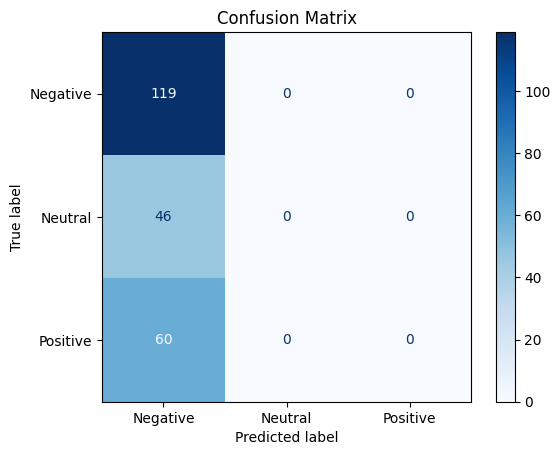

In [108]:
# Prepare test data
test_dataset = torch.utils.data.TensorDataset(test_embeddings, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the classifier
classifier.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = classifier(embeddings)
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices

        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Compute metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

if np.array(all_true_labels).ndim > 1:
    all_true_labels = np.argmax(all_true_labels, axis=1)

if np.array(all_predictions).ndim > 1:
    all_predictions = np.argmax(all_predictions, axis=1)


accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed report
print("Classification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
